In [ ]:
#!pip install lightautoml optuna catboost lightgbm scikit-learn pandas numpy matplotlib -q

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn.metrics import root_mean_squared_error

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

'nlp' extra dependency package 'fasttext-numpy2' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


d:\vscode_projects\itmo_AutoML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\vscode_projects\itmo_AutoML\.venv\Lib\site-packages\lightautoml\text\tokenizer.py:21: UserWarning: 'nltk' - package isn't installed
  warnings.warn("'nltk' - package isn't installed")
d:\vscode_projects\itmo_AutoML\.venv\Lib\site-packages\lightautoml\transformers\text.py:23: UserWarning: 'fasttext' - package isn't installed
  warnings.warn("'fasttext' - package isn't installed")


In [2]:
train_df = pd.read_csv(r"data/road/train.csv")
test_df = pd.read_csv(r"data/road/test.csv")

target_col = "accident_risk"

# 1. Target EDA

In [3]:
# Numeric target analysis + outlier detection via quantiles/IQR
desc = train_df[target_col].describe(percentiles=[0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])
display(desc)

# IQR-based bounds
q1, q3 = desc["25%"], desc["75%"]
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
anom_mask = (train_df[target_col] < lower) | (train_df[target_col] > upper)
anom_count = anom_mask.sum()
print(f"IQR bounds: [{lower:.4f}, {upper:.4f}], anomalies: {anom_count} ({anom_count/len(train_df):.4%})")

count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
0.1%          0.000000
1%            0.030000
5%            0.090000
10%           0.140000
25%           0.230000
50%           0.340000
75%           0.460000
90%           0.580000
95%           0.650000
99%           0.780000
99.9%         0.890000
max           1.000000
Name: accident_risk, dtype: float64

IQR bounds: [-0.1150, 0.8050], anomalies: 3367 (0.6503%)


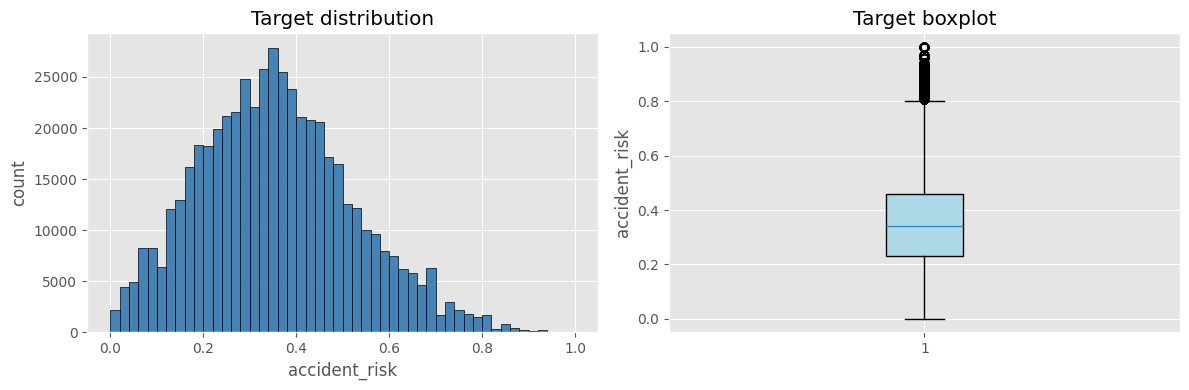

In [4]:
# Visualization: distribution and boxplot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(train_df[target_col], bins=50, color="steelblue", edgecolor="black")
axes[0].set_title("Target distribution")
axes[0].set_xlabel(target_col)
axes[0].set_ylabel("count")

axes[1].boxplot(train_df[target_col], vert=True, patch_artist=True, boxprops=dict(facecolor="lightblue"))
axes[1].set_title("Target boxplot")
axes[1].set_ylabel(target_col)
plt.tight_layout()
plt.show()

# 2. Feature EDA

In [5]:
# Typing
num_cols = train_df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = train_df.select_dtypes(include=["object", "category"]).columns.tolist()
bool_cols = train_df.select_dtypes(include=["bool"]).columns.tolist()
print(f"Numeric: {len(num_cols)} -> {num_cols}")
print(f"Categorical: {len(cat_cols)} -> {cat_cols}")
print(f"Bool: {len(bool_cols)} -> {bool_cols}")

Numeric: 6 -> ['id', 'num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'accident_risk']
Categorical: 4 -> ['road_type', 'lighting', 'weather', 'time_of_day']
Bool: 4 -> ['road_signs_present', 'public_road', 'holiday', 'school_season']


In [6]:
# Missing values
na_counts = train_df.isna().sum().sort_values(ascending=False)
na_pct = (na_counts / len(train_df) * 100).round(4)
missing_df = pd.DataFrame({"missing": na_counts, "missing_%": na_pct})
display(missing_df[missing_df["missing"] > 0])

,missing,missing_%


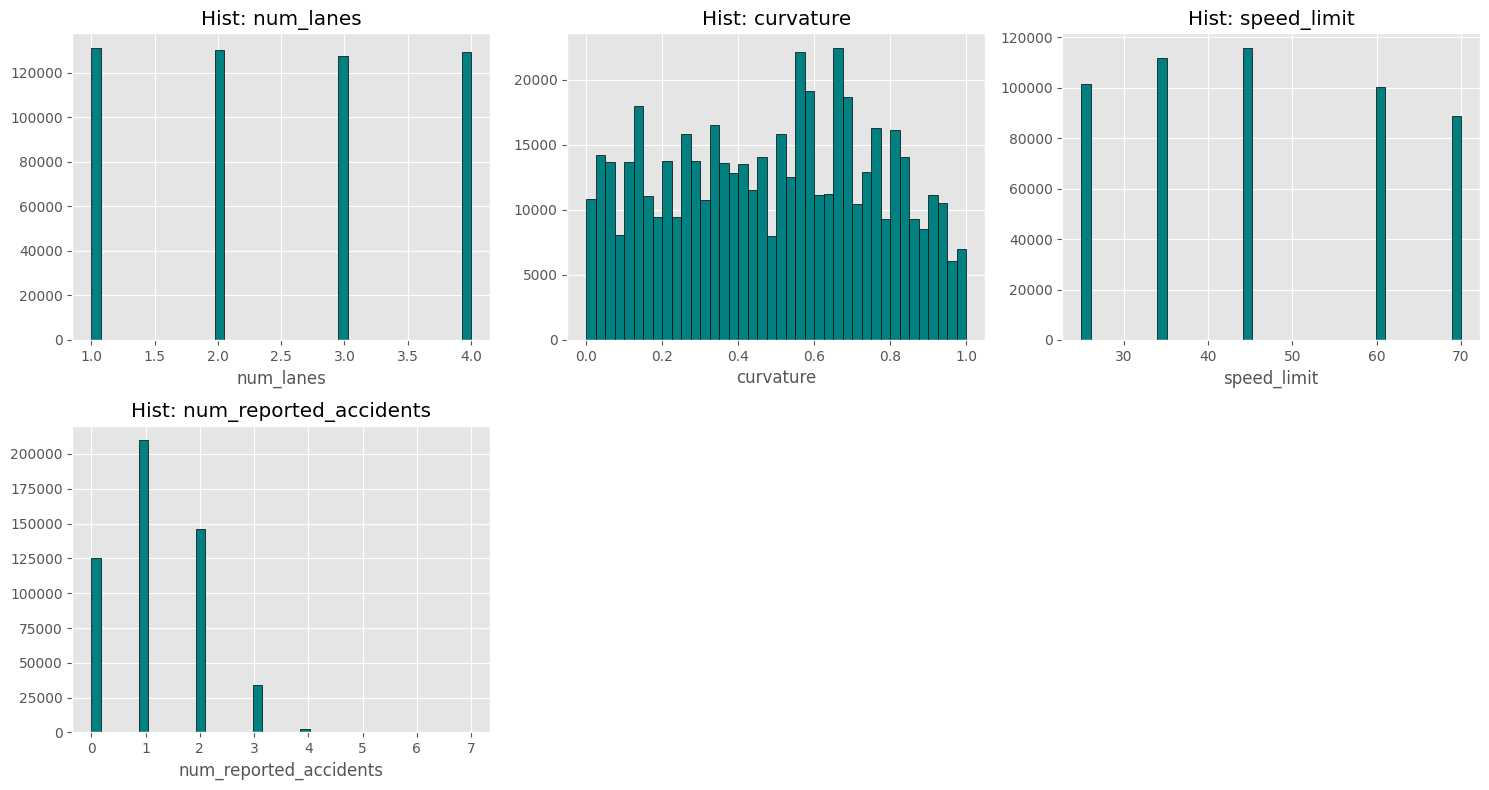

In [7]:
# Distributions for numeric features
plot_nums = [c for c in num_cols if c not in [target_col, "id"]]
ncols = 3
nrows = int(np.ceil(len(plot_nums) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = axes.flatten()
for ax, col in zip(axes, plot_nums):
    ax.hist(train_df[col], bins=40, color='teal', edgecolor='black')
    ax.set_title(f"Hist: {col}")
    ax.set_xlabel(col)
for ax in axes[len(plot_nums):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

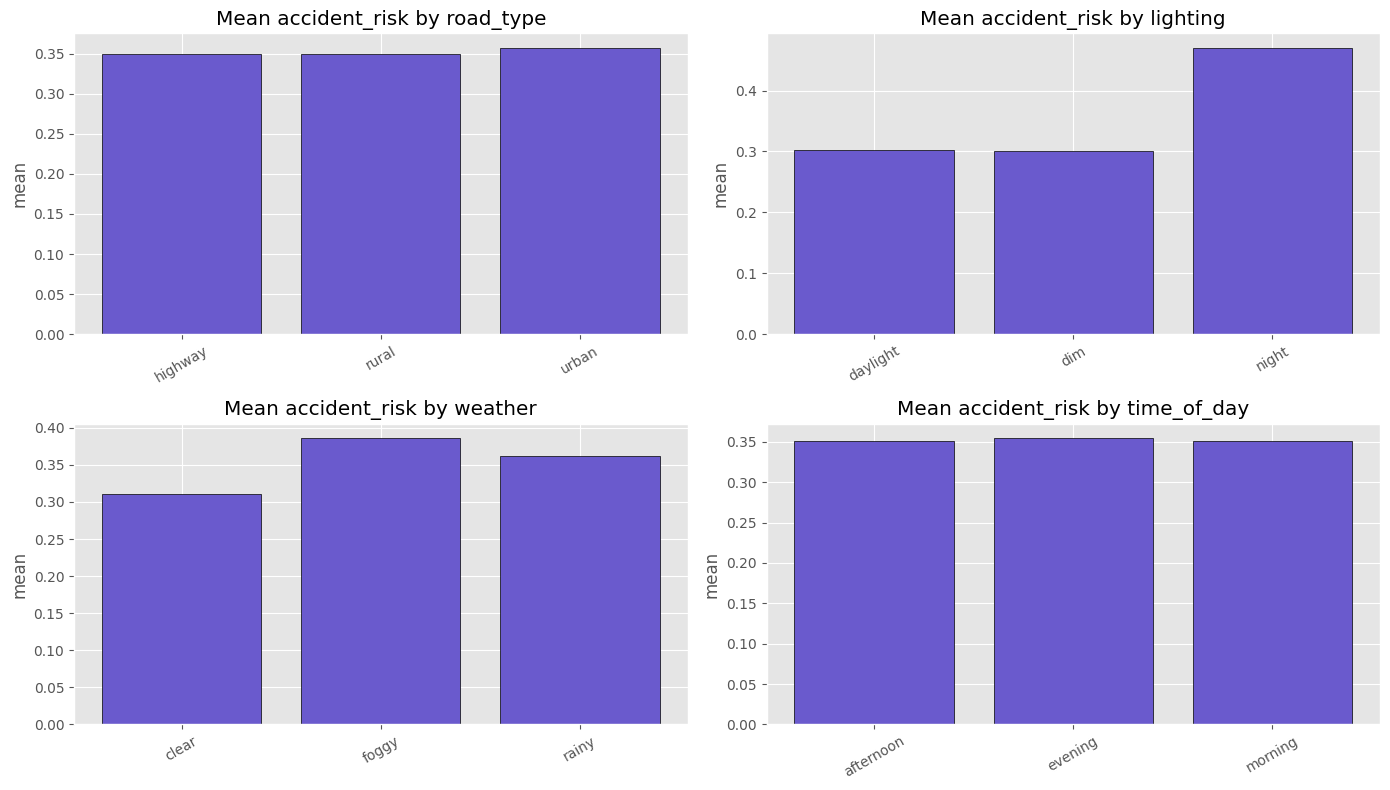

In [8]:
# Target mean by top categories
ncols = 2
nrows = int(np.ceil(len(cat_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 4*nrows))
axes = axes.flatten()
for ax, cat in zip(axes, cat_cols):
    top_vals = train_df[cat].value_counts().index
    grp = train_df[train_df[cat].isin(top_vals)].groupby(cat)[target_col].agg(['count','mean']).reset_index()
    x = range(len(grp))
    ax.bar(x, grp['mean'], color='slateblue', edgecolor='black')
    ax.set_title(f"Mean {target_col} by {cat}")
    ax.set_xticks(x)
    ax.set_xticklabels(grp[cat], rotation=30)
    ax.set_ylabel("mean")
for ax in axes[len(cat_cols):]:
    ax.set_visible(False)
plt.tight_layout()
plt.show()

In [9]:
# Anomalies per numeric feature via IQR
anom_report = []
for col in num_cols:
    if col == target_col:
        continue
    q1, q3 = train_df[col].quantile(0.25), train_df[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask = (train_df[col] < lower) | (train_df[col] > upper)
    cnt = mask.sum()
    if cnt:
        anom_report.append((col, cnt, round(cnt / len(train_df), 6), lower, upper))

if anom_report:
    anom_df = pd.DataFrame(anom_report, columns=["feature", "anomalies", "frac", "lower", "upper"])
    display(anom_df.sort_values("anomalies", ascending=False))
else:
    print("No numeric anomalies by IQR rule.")

,feature,anomalies,frac,lower,upper
0,num_reported_accidents,2649,0.005116,-0.5,3.5


In [10]:
# Correlations with target + multicollinearity check
num_corr = train_df[num_cols].corr()[target_col].sort_values(ascending=False)
print("Numeric correlations with target:")
print(num_corr)

# Multicollinearity: pairs with |corr| > 0.8 (excluding target/id)
corr_matrix = train_df[num_cols].drop(columns=[target_col, "id"], errors="ignore").corr().abs()
high_pairs = []
cols = corr_matrix.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        val = corr_matrix.iloc[i, j]
        if val > 0.8:
            high_pairs.append((cols[i], cols[j], val))

if high_pairs:
    print("\nHighly correlated numeric pairs (|corr| > 0.8):")
    for a, b, v in sorted(high_pairs, key=lambda x: x[2], reverse=True):
        print(f"{a} vs {b}: {v:.3f}")
else:
    print("\nNo numeric pairs with |corr| > 0.8")

Numeric correlations with target:
accident_risk             1.000000
curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
id                        0.000969
num_lanes                -0.006003
Name: accident_risk, dtype: float64

No numeric pairs with |corr| > 0.8


In [11]:
train_df.road_type.value_counts()

road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64

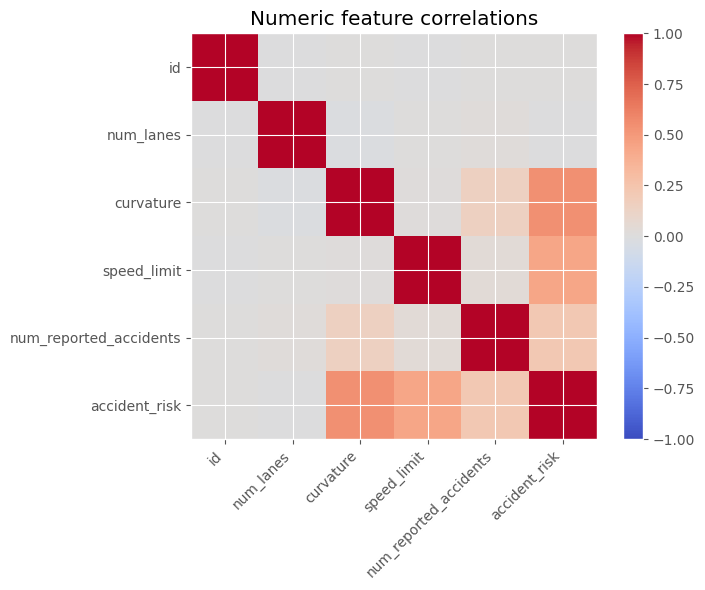

In [12]:
# Correlation heatmap for numeric features
corr_matrix = train_df[num_cols].corr()
plt.figure(figsize=(8,6))
im = plt.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Numeric feature correlations")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.tight_layout()
plt.show()

### 2.1 Идеи по преобразованиям / новым признакам
- Ограничить экстремальные значения числовых (IQR-клиппинг) для сильных перекосов.
- Взаимодействия: `speed_limit * curvature`, `num_lanes * public_road`, аварийность на полосу (`num_reported_accidents / num_lanes`).

# 3. Data preparation
- Две версии: **raw** (без FE) и **FE** (IQR-клиппинг + взаимодействия).
- Границы IQR считаем только на train, потом клипим train/test — без лика.
- Train/valid: hold-out 80/20 перед обучением; valid передаём в `valid_data` LAMA.


In [13]:
from sklearn.model_selection import train_test_split

num_base = [c for c in num_cols if c not in [target_col, 'id']]

def compute_iqr_bounds(df, cols):
    bounds = {}
    for c in cols:
        q1, q3 = df[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        bounds[c] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    return bounds

def apply_clip(df, bounds):
    out = df.copy()
    for c, (lo, hi) in bounds.items():
        out[c] = out[c].clip(lo, hi)
    return out

def add_interactions(df):
    out = df.copy()
    out['speed_curvature'] = out['speed_limit'] * out['curvature']
    out['lanes_public'] = out['num_lanes'] * out['public_road'].astype(int)
    out['accidents_per_lane'] = out['num_reported_accidents'] / np.where(out['num_lanes'] == 0, np.nan, out['num_lanes'])
    return out

iqr_bounds = compute_iqr_bounds(train_df, num_base)

train_fe = add_interactions(apply_clip(train_df, iqr_bounds))
test_fe = add_interactions(apply_clip(test_df, iqr_bounds))

train_raw, valid_raw = train_test_split(train_df, test_size=0.2, random_state=42)
train_fe_split, valid_fe_split = train_test_split(train_fe, test_size=0.2, random_state=42)

# 4. LAMA: конфигурации и запуск
- Разделяем на train/valid заранее
- Минимум 2 конфигурации (fast/extended) для raw и FE. Выбор по OOF-RMSE

In [ ]:
roles = {'target': target_col, 'drop': ['id']}

cpu_limit = os.cpu_count()

def run_lama(cfg, train_data, valid_data):
    task = Task('reg', metric='mse')
    automl = TabularAutoML(
        task=task,
        timeout=cfg['timeout'],
        cpu_limit=cpu_limit,
        reader_params={'cv': cfg.get('cv', 3), 'random_state': 42},
    )
    automl.fit_predict(train_data, roles=roles, valid_data=valid_data, verbose=1)
    valid_pred = automl.predict(valid_data)
    preds = valid_pred.data[:, 0]
    rmse = root_mean_squared_error(valid_data[target_col], preds)
    print(f"{cfg['name']} valid RMSE: {rmse:.5f}")
    return automl, rmse

configs = [
    {'name': 'raw_fast', 'timeout': 120, 'cv': 3, 'data': (train_raw, valid_raw, test_df)},
    {'name': 'raw_extended', 'timeout': 240, 'cv': 5, 'data': (train_raw, valid_raw, test_df)},
    {'name': 'fe_fast', 'timeout': 120, 'cv': 3, 'data': (train_fe_split, valid_fe_split, test_fe)},
    {'name': 'fe_extended', 'timeout': 240, 'cv': 5, 'data': (train_fe_split, valid_fe_split, test_fe)},
]

results = []
for cfg in configs:
    model, rmse = run_lama(cfg, cfg['data'][0], cfg['data'][1])
    results.append((rmse, cfg, model))

best_rmse, best_cfg, best_model = min(results, key=lambda x: x[0])
print(f"\nBest config: {best_cfg['name']} (RMSE={best_rmse:.5f})")

[21:01:59] Stdout logging level is INFO.
[21:01:59] Task: reg

[21:01:59] Start automl preset with listed constraints:
[21:01:59] - time: 120.00 seconds
[21:01:59] - CPU: 16 cores
[21:01:59] - memory: 16 GB

[21:01:59] Train data shape: (414203, 14)

[21:02:09] Layer 1 train process start. Time left 110.21 secs
[21:02:20] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[21:02:20] Time left 98.91 secs

[21:02:24] Selector_LightGBM fitting and predicting completed
[21:02:27] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[21:02:27] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 10.36 secs


Optimization Progress:   3%|▎         | 3/101 [00:11<06:27,  3.95s/it, best_trial=2, best_value=-0.0111]

[21:02:39] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[21:03:16] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[21:03:16] Time left 43.16 secs

[21:03:16] Layer 1 training completed.

[21:03:16] Blending: optimization starts with equal weights. Score = -0.0082967
[21:03:16] Blending: iteration 0: score = -0.0059628, weights = [0.76867735 0.08232978 0.07942136 0.06957157]
[21:03:16] Blending: iteration 1: score = -0.0059620, weights = [0.76858467 0.08740143 0.08186611 0.06214786]
[21:03:16] Blending: iteration 2: score = -0.0059614, weights = [0.76848406 0.09224847 0.08445016 0.0548173 ]
[21:03:16] Blending: iteration 3: score = -0.0059611, weights = [0.76335096 0.09429379 0.08632258 0.0560327 ]
[21:03:16] Blending: no improvements for score. Terminated.

[21:03:16] Blending: best score = -0.0059611, best weights = [0.76335096 0.09429379 0.08632258 0.0560327 ]
[21:03:16] Automl preset training completed in 77.32 seconds

[21:03:16] Model description:
Final prediction for new objects (level 0) = 
	 0.76335 * (1 averaged model

Optimization Progress:   8%|▊         | 8/101 [00:39<07:34,  4.89s/it, best_trial=2, best_value=-0.0111]

[21:04:25] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[21:05:04] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[21:05:04] Time left 133.80 secs

[21:05:04] Layer 1 training completed.

[21:05:04] Blending: optimization starts with equal weights. Score = -0.0082722
[21:05:04] Blending: iteration 0: score = -0.0059083, weights = [0.7703496  0.08164402 0.078821   0.06918539]
[21:05:04] Blending: iteration 1: score = -0.0059077, weights = [0.77025646 0.08648746 0.08127458 0.06198154]
[21:05:04] Blending: iteration 2: score = -0.0059070, weights = [0.7701614  0.0911475  0.08384214 0.05484901]
[21:05:04] Blending: iteration 3: score = -0.0059068, weights = [0.765137   0.09314001 0.08567496 0.05604803]
[21:05:04] Blending: no improvements for score. Terminated.

[21:05:04] Blending: best score = -0.0059068, best weights = [0.765137   0.09314001 0.08567496 0.05604803]
[21:05:04] Automl preset training completed in 106.68 seconds

[21:05:04] Model description:
Final prediction for new objects (level 0) = 
	 0.76514 * (1 averaged mod

Optimization Progress:   3%|▎         | 3/101 [00:11<06:08,  3.76s/it, best_trial=2, best_value=-0.0111]

[21:05:46] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[21:06:25] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[21:06:25] Time left 40.60 secs

[21:06:25] Layer 1 training completed.

[21:06:25] Blending: optimization starts with equal weights. Score = -0.0083129
[21:06:25] Blending: iteration 0: score = -0.0059834, weights = [0.7686564  0.08119249 0.07855828 0.07159286]
[21:06:26] Blending: iteration 1: score = -0.0059830, weights = [0.7685987  0.08517547 0.08007579 0.06615012]
[21:06:26] Blending: iteration 2: score = -0.0059826, weights = [0.7685408  0.08904175 0.08165973 0.06075774]
[21:06:26] Blending: iteration 3: score = -0.0059822, weights = [0.7684812  0.09280992 0.083303   0.0554059 ]
[21:06:26] Blending: iteration 4: score = -0.0059818, weights = [0.7684168  0.10140049 0.08008882 0.0500939 ]
[21:06:26] Blending: best score = -0.0059818, best weights = [0.7684168  0.10140049 0.08008882 0.0500939 ]
[21:06:26] Automl preset training completed in 79.92 seconds

[21:06:26] Model description:
Final prediction for new o

Optimization Progress:  10%|▉         | 10/101 [00:38<05:47,  3.82s/it, best_trial=8, best_value=-0.0111]

[21:07:34] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[21:08:12] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[21:08:12] Time left 134.82 secs

[21:08:12] Layer 1 training completed.

[21:08:12] Blending: optimization starts with equal weights. Score = -0.0082576
[21:08:13] Blending: iteration 0: score = -0.0058926, weights = [0.7670136  0.08142457 0.07933652 0.07222532]
[21:08:13] Blending: iteration 1: score = -0.0058922, weights = [0.76695406 0.08508843 0.0810939  0.06686356]
[21:08:13] Blending: iteration 2: score = -0.0058918, weights = [0.7668993  0.08864052 0.08290365 0.06155657]
[21:08:13] Blending: iteration 3: score = -0.0058915, weights = [0.766838   0.09221519 0.08469783 0.05624901]
[21:08:13] Blending: iteration 4: score = -0.0058911, weights = [0.76677334 0.10050002 0.08170994 0.05101671]
[21:08:13] Blending: best score = -0.0058911, best weights = [0.76677334 0.10050002 0.08170994 0.05101671]
[21:08:13] Automl preset training completed in 105.67 seconds

[21:08:13] Model description:
Final prediction for new

In [26]:
_, _, best_test = best_cfg['data']
test_pred = best_model.predict(best_test)
pred_values = test_pred.data[:, 0] if hasattr(test_pred, 'data') else test_pred[:, 0]
submission = pd.DataFrame({
    'id': best_test['id'],
    target_col: pred_values.clip(0, 1),
})
submission_path = 'data/road/submission.csv'
submission.to_csv(submission_path, index=False)
print(f'Saved submission to {submission_path}')

Saved submission to data/road/submission.csv


# 5. Ручные модели (Linear / CatBoost / LightGBM)

In [ ]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_predict
import catboost as cb
import lightgbm as lgb
from tqdm.autonotebook import tqdm

In [ ]:
def get_linear_pipeline(data):
    """Собирает пайплайн для линейной модели: OneHot для категорий, StandardScaler для числовых, затем Ridge."""
    cats = [c for c in data.columns if c not in num_base + [target_col, 'id']]
    nums = [c for c in data.columns if c in num_base]
    preproc = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), cats),
        ('num', StandardScaler(), nums)
    ])
    model = Ridge(random_state=42)
    return Pipeline([('prep', preproc), ('model', model)])

def eval_model(model, X, y, cv_splits=3):
    """Считает RMSE на KFold, используя cross_val_predict для указанной модели."""
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    preds = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)
    return root_mean_squared_error(y, preds)


In [ ]:
def tune_linear(data, name, n_trials=15):
    """Подбирает alpha для Ridge через Optuna и обучает модель на всём train."""
    X = data.drop(columns=[target_col])
    y = data[target_col]
    def objective(trial):
        alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
        pipeline = get_linear_pipeline(data)
        pipeline.named_steps['model'].set_params(alpha=alpha)
        return eval_model(pipeline, X, y, cv_splits=3)
    study = optuna.create_study(direction='minimize', study_name=f'linear_{name}', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best_alpha = study.best_params['alpha']
    best_model = get_linear_pipeline(data)
    best_model.named_steps['model'].set_params(alpha=best_alpha)
    best_model.fit(X, y)
    print(f"[Linear {name}] best alpha={best_alpha:.5f}, best RMSE={study.best_value:.5f}")
    return best_model, study.best_value


In [ ]:
def tune_catboost(data, name, n_trials=20):
    """Подбирает гиперпараметры CatBoost через Optuna и обучает модель."""
    X = data.drop(columns=[target_col])
    y = data[target_col]
    cat_features = [i for i,c in enumerate(X.columns) if X[c].dtype=='object' or X[c].dtype=='bool']
    def objective(trial):
        params = {
            'depth': trial.suggest_int('depth', 3, 6),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
            'iterations': trial.suggest_int('iterations', 100, 200),
            'loss_function': 'RMSE',
            'verbose': False,
            'random_seed': 42,
        }
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        rmses = []
        for tr_idx, val_idx in kf.split(X):
            train_pool = cb.Pool(X.iloc[tr_idx], y.iloc[tr_idx], cat_features=cat_features)
            val_pool = cb.Pool(X.iloc[val_idx], y.iloc[val_idx], cat_features=cat_features)
            model = cb.CatBoostRegressor(**params)
            model.fit(train_pool)
            preds = model.predict(val_pool)
            rmses.append(root_mean_squared_error(y.iloc[val_idx], preds))
        return np.mean(rmses)
    study = optuna.create_study(direction='minimize', study_name=f'cat_{name}', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best = study.best_params
    final_model = cb.CatBoostRegressor(**best, loss_function='RMSE', verbose=False, random_seed=42)
    final_model.fit(X, y, cat_features=cat_features)
    print(f"[CatBoost {name}] best RMSE={study.best_value:.5f}, params={best}")
    return final_model, study.best_value

def tune_lightgbm(data, name, n_trials=20):
    """Подбирает гиперпараметры LightGBM через Optuna и обучает модель."""
    X = data.drop(columns=[target_col])
    y = data[target_col]
    cat_cols_local = [c for c in X.columns if X[c].dtype=='object' or X[c].dtype=='bool']
    for c in cat_cols_local:
        X[c] = X[c].astype('category')
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 63),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
            'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
            'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
            'seed': 42,
            'verbose': -1,
        }
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        rmses = []
        for tr_idx, val_idx in kf.split(X):
            lgb_train = lgb.Dataset(X.iloc[tr_idx], y.iloc[tr_idx], categorical_feature=cat_cols_local, free_raw_data=True)
            lgb_val = lgb.Dataset(X.iloc[val_idx], y.iloc[val_idx], categorical_feature=cat_cols_local, free_raw_data=True)
            model = lgb.train(params, lgb_train, num_boost_round=trial.suggest_int('n_estimators', 100, 200), valid_sets=[lgb_val])
            preds = model.predict(X.iloc[val_idx])
            rmses.append(root_mean_squared_error(y.iloc[val_idx], preds))
        return np.mean(rmses)
    study = optuna.create_study(direction='minimize', study_name=f'lgbm_{name}', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    best = study.best_params
    final_model = lgb.LGBMRegressor(**{k: v for k, v in best.items() if k not in ['metric', 'objective']}, objective='regression', metric='rmse', random_state=42)
    final_model.fit(X, y, categorical_feature=cat_cols_local)
    print(f"[LightGBM {name}] best RMSE={study.best_value:.5f}, params={best}")
    return final_model, study.best_value


### 5.1 Linear (Ridge + OneHot)

In [42]:
lin_models = []
for name, dtrain, dvalid in [
    ('raw', train_raw, valid_raw),
    ('fe', train_fe_split, valid_fe_split),
]:
    print(f"\n=== Linear {name} ===")
    model, score = tune_linear(dtrain, name, n_trials=15)
    lin_models.append((score, f'linear_{name}', model, dtrain, dvalid))

best_linear = min(lin_models, key=lambda x: x[0])
print(f"Best Linear: {best_linear[1]} RMSE={best_linear[0]:.5f}")


=== Linear raw ===
[Linear raw] best alpha=2.14230, best RMSE=0.07349

=== Linear fe ===
[Linear fe] best alpha=0.45706, best RMSE=0.06107
Best Linear: linear_fe RMSE=0.06107


In [ ]:
# Make and save test preds

rmse_val, name, model, dtrain, _ = best_linear
test_used = test_fe if 'fe' in name else test_df
preds = model.predict(test_used)
submission = pd.DataFrame({
    'id': test_used['id'],
    target_col: np.array(preds).ravel().clip(0, 1),
})
out_path = f"data/road/submission_{name}.csv"
submission.to_csv(out_path, index=False)
print(f"Saved {out_path}")

Saved data/road/submission_linear_fe.csv


### 5.2 CatBoost

In [54]:
cat_models = []
for name, dtrain, dvalid in [
    ('raw', train_raw, valid_raw),
    ('fe', train_fe_split, valid_fe_split),
]:
    print(f"\n=== CatBoost {name} ===")
    model, score = tune_catboost(dtrain, name, n_trials=10)
    cat_models.append((score, f'cat_{name}', model, dtrain, dvalid))

best_cat = min(cat_models, key=lambda x: x[0])
print(f"Best CatBoost: {best_cat[1]} RMSE={best_cat[0]:.5f}")

[I 2025-12-08 22:03:51,060] A new study created in memory with name: cat_raw



=== CatBoost raw ===


[I 2025-12-08 22:04:27,894] Trial 0 finished with value: 0.05645847221252225 and parameters: {'depth': 4, 'learning_rate': 0.2536999076681772, 'l2_leaf_reg': 7.587945476302646, 'iterations': 160}. Best is trial 0 with value: 0.05645847221252225.
[I 2025-12-08 22:05:04,366] Trial 1 finished with value: 0.06270913534061519 and parameters: {'depth': 3, 'learning_rate': 0.01699897838270077, 'l2_leaf_reg': 1.5227525095137953, 'iterations': 187}. Best is trial 0 with value: 0.05645847221252225.
[I 2025-12-08 22:05:48,943] Trial 2 finished with value: 0.056438279399464115 and parameters: {'depth': 5, 'learning_rate': 0.11114989443094977, 'l2_leaf_reg': 1.185260448662222, 'iterations': 197}. Best is trial 2 with value: 0.056438279399464115.
[I 2025-12-08 22:06:24,354] Trial 3 finished with value: 0.06130747785120488 and parameters: {'depth': 6, 'learning_rate': 0.020589728197687916, 'l2_leaf_reg': 2.636424704863906, 'iterations': 118}. Best is trial 2 with value: 0.056438279399464115.
[I 2025-

[CatBoost raw] best RMSE=0.05644, params={'depth': 5, 'learning_rate': 0.11114989443094977, 'l2_leaf_reg': 1.185260448662222, 'iterations': 197}

=== CatBoost fe ===


[I 2025-12-08 22:10:41,280] Trial 0 finished with value: 0.05649276989167571 and parameters: {'depth': 4, 'learning_rate': 0.2536999076681772, 'l2_leaf_reg': 7.587945476302646, 'iterations': 160}. Best is trial 0 with value: 0.05649276989167571.
[I 2025-12-08 22:11:16,640] Trial 1 finished with value: 0.06428047747610917 and parameters: {'depth': 3, 'learning_rate': 0.01699897838270077, 'l2_leaf_reg': 1.5227525095137953, 'iterations': 187}. Best is trial 0 with value: 0.05649276989167571.
[I 2025-12-08 22:12:00,027] Trial 2 finished with value: 0.05645384298507967 and parameters: {'depth': 5, 'learning_rate': 0.11114989443094977, 'l2_leaf_reg': 1.185260448662222, 'iterations': 197}. Best is trial 2 with value: 0.05645384298507967.
[I 2025-12-08 22:12:35,208] Trial 3 finished with value: 0.06148452368425603 and parameters: {'depth': 6, 'learning_rate': 0.020589728197687916, 'l2_leaf_reg': 2.636424704863906, 'iterations': 118}. Best is trial 2 with value: 0.05645384298507967.
[I 2025-12-

[CatBoost fe] best RMSE=0.05645, params={'depth': 5, 'learning_rate': 0.11114989443094977, 'l2_leaf_reg': 1.185260448662222, 'iterations': 197}
Best CatBoost: cat_raw RMSE=0.05644


In [ ]:
# Make and save test preds
rmse_val, name, model, dtrain, _ = best_cat
cat_features = [i for i, c in enumerate(dtrain.columns) if dtrain[c].dtype == 'object' or dtrain[c].dtype == 'bool']
test_used = test_fe if 'fe' in name else test_df
test_pool = cb.Pool(test_used, cat_features=cat_features)

preds = model.predict(test_pool)
preds_arr = np.array(preds).ravel()

submission = pd.DataFrame({
    'id': test_used['id'],
    target_col: preds_arr.clip(0, 1),
})
out_path = f"data/road/submission_{name}.csv"
submission.to_csv(out_path, index=False)

### 5.3 LightGBM

In [50]:
lgbm_models = []
for name, dtrain, dvalid in [
    ('raw', train_raw, valid_raw),
    ('fe', train_fe_split, valid_fe_split),
]:
    print(f"\n=== LightGBM {name} ===")
    model, score = tune_lightgbm(dtrain, name, n_trials=10)
    lgbm_models.append((score, f'lgbm_{name}', model, dtrain, dvalid))

best_lgbm = min(lgbm_models, key=lambda x: x[0])
print(f"Best LightGBM: {best_lgbm[1]} RMSE={best_lgbm[0]:.5f}")

[I 2025-12-08 21:53:37,779] A new study created in memory with name: lgbm_raw



=== LightGBM raw ===


[I 2025-12-08 21:53:43,576] Trial 0 finished with value: 0.05614634247445747 and parameters: {'lr': 0.03574712922600244, 'num_leaves': 61, 'feature_fraction': 0.9195981825434215, 'bagging_fraction': 0.8795975452591109, 'bagging_freq': 1, 'lambda_l1': 0.7799726016810132, 'lambda_l2': 0.2904180608409973, 'n_estimators': 187}. Best is trial 0 with value: 0.05614634247445747.
[I 2025-12-08 21:53:47,826] Trial 1 finished with value: 0.05618556204565484 and parameters: {'lr': 0.07725378389307355, 'num_leaves': 49, 'feature_fraction': 0.7061753482887407, 'bagging_fraction': 0.9909729556485982, 'bagging_freq': 5, 'lambda_l1': 1.0616955533913808, 'lambda_l2': 0.9091248360355031, 'n_estimators': 118}. Best is trial 0 with value: 0.05614634247445747.
[I 2025-12-08 21:53:52,235] Trial 2 finished with value: 0.05682836292355914 and parameters: {'lr': 0.028145092716060652, 'num_leaves': 40, 'feature_fraction': 0.8295835055926347, 'bagging_fraction': 0.7873687420594125, 'bagging_freq': 4, 'lambda_l1'

[LightGBM raw] best RMSE=0.05615, params={'lr': 0.03574712922600244, 'num_leaves': 61, 'feature_fraction': 0.9195981825434215, 'bagging_fraction': 0.8795975452591109, 'bagging_freq': 1, 'lambda_l1': 0.7799726016810132, 'lambda_l2': 0.2904180608409973, 'n_estimators': 187}

=== LightGBM fe ===


[I 2025-12-08 21:54:34,801] Trial 0 finished with value: 0.05618631766539451 and parameters: {'lr': 0.03574712922600244, 'num_leaves': 61, 'feature_fraction': 0.9195981825434215, 'bagging_fraction': 0.8795975452591109, 'bagging_freq': 1, 'lambda_l1': 0.7799726016810132, 'lambda_l2': 0.2904180608409973, 'n_estimators': 187}. Best is trial 0 with value: 0.05618631766539451.
[I 2025-12-08 21:54:39,562] Trial 1 finished with value: 0.05622330829027564 and parameters: {'lr': 0.07725378389307355, 'num_leaves': 49, 'feature_fraction': 0.7061753482887407, 'bagging_fraction': 0.9909729556485982, 'bagging_freq': 5, 'lambda_l1': 1.0616955533913808, 'lambda_l2': 0.9091248360355031, 'n_estimators': 118}. Best is trial 0 with value: 0.05618631766539451.
[I 2025-12-08 21:54:44,671] Trial 2 finished with value: 0.056775094454175494 and parameters: {'lr': 0.028145092716060652, 'num_leaves': 40, 'feature_fraction': 0.8295835055926347, 'bagging_fraction': 0.7873687420594125, 'bagging_freq': 4, 'lambda_l1

[LightGBM fe] best RMSE=0.05619, params={'lr': 0.03574712922600244, 'num_leaves': 61, 'feature_fraction': 0.9195981825434215, 'bagging_fraction': 0.8795975452591109, 'bagging_freq': 1, 'lambda_l1': 0.7799726016810132, 'lambda_l2': 0.2904180608409973, 'n_estimators': 187}
Best LightGBM: lgbm_raw RMSE=0.05615


In [ ]:
# Make and save test preds

rmse_val, name, model, dtrain, _ = best_lgbm

cat_cols_local = [c for c in dtrain.columns if dtrain[c].dtype == 'object' or dtrain[c].dtype == 'bool']
for c in cat_cols_local:
    dtrain[c] = dtrain[c].astype('category')
test_used = test_fe if 'fe' in name else test_df
for c in cat_cols_local:
    test_used[c] = test_used[c].astype('category')

preds = model.predict(test_used)
preds_arr = np.array(preds).ravel()

submission = pd.DataFrame({
    'id': test_used['id'],
    target_col: preds_arr.clip(0, 1),
})
out_path = f"data/road/submission_{name}.csv"
submission.to_csv(out_path, index=False)
print(f"Saved {out_path}")

Saved data/road/submission_lgbm_raw.csv


# Выводы

LAMA отличный инструмент, которому скорее всего нужно больше времени инференса на то, чтобы выдать крутой результат. Все модели, которые я сделал руками побили скор модели от LAMA (метрики с kaggle):
- LAMA (FE): 0.078
- Linear Regression (FE): 0.06
- Catboost (Raw dataset): 0.056
- LGBM (Raw dataset): 0.056